In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
from typing import TypedDict, List, Optional, Dict

In [2]:
load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

In [3]:
class AgentState(TypedDict, total=False):
    url: str
    reply: Optional[str]
    script_summary: Optional[Dict[str, str | List[str]]]
    comment_summary: Optional[str]

graph_builder = StateGraph(AgentState)

In [4]:
# 라우터 설정 
class Route(BaseModel):
    target: Literal['summarize_script', 'summarize_comment'] = Field(
        description="The target for the query to answer"
    )

# 라우터 프롬프트 설정 
router_system_prompt = """
You are an expert at routing a user's message given these variables:
- URL: the YouTube video link (may be empty if none)
- 질문: the user's initial question or query

Classify a user's input into one of two categories: 'summarize_script' or 'summarize_comment'.

- If the message **does not contain a state[reply]** or **has blank state[reply]** (e.g., includes 'youtube.com' or 'youtu.be'), always route it to 'summarize_script'. 

- If the user's message is a **positive or affirmative response to a question like** "영상에 대한 댓글 반응도 궁금하시다면 알려드릴게요!" — such as "응", "네", "보여줘", "궁금해", etc., then route it to 'summarize_comment'.

- If the user does not respond or responds **negatively** (e.g., "괜찮아", "글쎄", "아니"), **do not route anywhere**. This means the flow should end silently.
"""

# 라우터 프롬프트 템플릿 설정
router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", "URL: {url}\n사용자 답변: {reply}")
])

# 라우터 형식으로 구조화한 llm 설정
structured_router_llm = llm.with_structured_output(Route)

In [5]:
def router(state: AgentState) -> Literal['summarize_script', 'commentsummarize_comment_summary']:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다

    Args:
        state (AgentState): 에이전트의 현재 상태를 나타내는 딕셔너리

    Returns:
        AgentState: Literal['summarize_script', 'summarize_comment']: 쿼리에 따라 선택된 경로를 반환합니다.
    """

    url = state.get('url', '')
    reply = state.get('reply', '')
    
    router_chain = router_prompt | structured_router_llm
    route = router_chain.invoke({"url": url, "reply": reply})

    return route.target

In [6]:
from script_agent_05 import graph as script_agent
from comment_agent_05 import graph as comment_agent

In [7]:
graph_builder.add_node('summarize_script', script_agent)
graph_builder.add_node('summarize_comment', comment_agent)

In [8]:
graph_builder.add_conditional_edges(
    START,
    router,
    {   # 리턴값 :  노드이름 
        'summarize_script': 'summarize_script',
        'summarize_comment': 'summarize_comment',
    }
)

graph_builder.add_edge('summarize_script', END)
graph_builder.add_edge('summarize_comment', END)

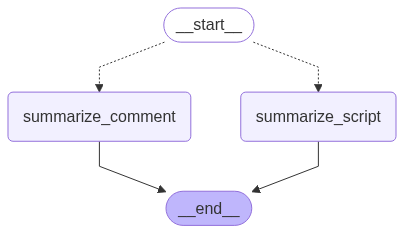

In [9]:
graph = graph_builder.compile()
graph

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_memory = graph_builder.compile(checkpointer=memory)

In [ ]:
def continue_with_memory(graph, memory, config: dict, update: dict):
    snapshot = memory.get_state(config)
    previous_state = snapshot._asdict()
    new_state = {**previous_state, **update}
    return graph.invoke(new_state, config=config)

In [12]:
config = {"configurable": {"thread_id": "1"}}
url = 'https://youtu.be/sLe6jgHoYtk?si=BP39AJQL1PvIoWBe'


In [13]:
initial_state = {'url': url}
step1_state = graph.invoke(initial_state, config=config)
print("📄 스크립트 요약 결과:")
print(step1_state.get("script_summary", ""))

🚀 [Tool] get_youtube_transcript 호출됨
✅ 영상 ID 추출 성공: sLe6jgHoYtk
✅ 1. 자막 추출 성공
✅ 스크립트 추출 성공. 요약 단계로 이동합니다.
🚀 [Tool] summarize_transcript 호출됨
✅ 2. 요약 생성 성공
📄 스크립트 요약 결과:
```json
{
  "요약": "이 영상은 아침에 일어나거나 운동 전에 할 수 있는 모닝 스트레칭 루틴을 소개합니다. 스트레스를 줄이고 몸을 부드럽게 깨우는 데 효과적입니다. 동작들은 간단하며 몸의 긴장을 풀고 유연성을 높입니다.",
  "운동 강도": "모든 레벨",
  "운동 루틴": [
    "1. 🧘‍♀️ 누운 자세에서 호흡 - 코로 숨을 들이마시고 입으로 내쉬며 몸을 깨움",
    "2. 🤲 손가락과 발가락 스트레칭 - 손목과 발목을 구부렸다 펴며 긴장을 풀기",
    "3. 💪 팔 회전 - 팔꿈치로 큰 원을 그리며 어깨와 팔을 풀기",
    "4. 🦵 다리와 몸통 스트레칭 - 몸을 좌우로 기울이며 옆구리 늘리기",
    "5. 🦶 무릎 구부리기 - 무릎을 구부리고 다리를 뻗어 다리 근육 늘리기",
    "6. 🤸‍♂️ 옆으로 누워 팔 스트레칭 - 팔을 사선으로 뻗어 어깨와 가슴 열기",
    "7. 🙆‍♂️ 마무리 스트레칭 - 무릎 꿇거나 앉은 자세에서 목과 갈비뼈 스트레칭"
  ],
  "자극 신체 부위": "어깨, 허벅지, 종아리, 옆구리, 갈비뼈, 목",
  "영상에 대한 댓글 반응도 궁금하시다면 알려드릴게요!"
}
```


In [14]:
step2_state = continue_with_memory(graph, graph_memory, config, {"reply": "응", "url": step1_state.get("url")})
print("\n💬 댓글 요약 결과:")
print(step2_state.get("comment_summary", ""))

AttributeError: 'CompiledStateGraph' object has no attribute 'get'